In [1]:
import jax
import jax.numpy as np

from numpy.polynomial.hermite import hermgauss

from structure_vb_lib import structure_model_lib, posterior_quantities_lib, data_utils, plotting_utils
import structure_vb_lib.structure_optimization_lib as s_optim_lib

from bnpmodeling_runjingdev.sensitivity_lib import HyperparameterSensitivityLinearApproximation
from bnpmodeling_runjingdev.bnp_optimization_lib import optimize_kl
from bnpmodeling_runjingdev import influence_lib, cluster_quantities_lib, result_loading_utils
import bnpmodeling_runjingdev.functional_sensitivity_lib as func_sens_lib

import paragami

from copy import deepcopy

import time

import matplotlib.pyplot as plt
%matplotlib inline

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [26]:
save_data = True
out_datadir = '/scratch/users/genomic_times_series_bnp/bnp_sensitivity_paper_data/structure/'



# Load data

In [4]:
g_obs, _, labels, _ = data_utils.load_thrush_data()

loading thrush data from : 
../data/thrush_data/thrush-data.str


In [5]:
print(g_obs.shape)

(155, 7, 2, 21)


In [6]:
n_obs = g_obs.shape[0]
n_loci = g_obs.shape[1]
n_allele = g_obs.shape[-1]

In [7]:
onp.unique(labels)

array(['Chawia', 'Mbololo', 'Ngangao', 'Yale'], dtype='<U32')

# Load initial fit

In [8]:
vb_opt_dict, vb_params_paragami, init_fit_metadata = \
        paragami.load_folded('../fits/main_fits/structure_initial_fit.npz')
    
vb_opt = vb_params_paragami.flatten(vb_opt_dict, free = True)

In [9]:
# TODO we should save this too
gh_deg = 8
gh_loc, gh_weights = hermgauss(8)

# Load refits

In [10]:
out_folder = '../fits/main_fits/'
match_crit = 'structure_fsens_mbololo_epsilonindx\d+.npz'

In [11]:
refit_list, epsilon_vec, meta_data_list = \
    result_loading_utils.load_refit_files_epsilon(out_folder, match_crit)

In [12]:
print(epsilon_vec)

[0.  0.2 0.4 0.6 0.8 1. ]


# Plot initial fit

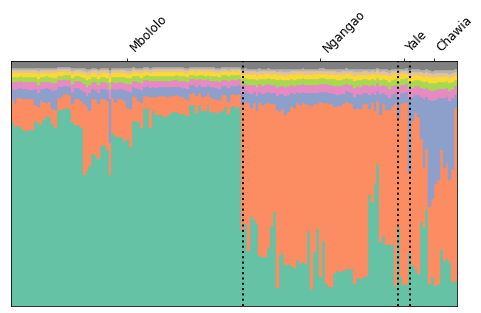

In [13]:
e_ind_admix = posterior_quantities_lib.get_vb_expectations(vb_opt_dict, gh_loc, gh_weights)[0]

# sort everything within populations
perm_obs = data_utils.cluster_admix_get_indx_within_labels(onp.array(e_ind_admix),
                                                               labels)

# now re-order populations: put chawia last
_labels = deepcopy(labels)
_labels[_labels == 'Chawia'] = 'z'
perm_labels = onp.argsort(_labels)
perm_obs = perm_obs[perm_labels]

# plot admixture
fig, ax = plt.subplots(1, 1, figsize = (8, 4.5))

plotting_utils.plot_top_clusters(onp.array(e_ind_admix)[perm_obs], 
                                 ax,
                                 8, 
                                 cmap_colors = plt.get_cmap('Set2').colors);

# print labels
plotting_utils.draw_region_separation(labels[perm_labels], ax);

# Load LR predictions

In [14]:
lr_list = result_loading_utils._load_meta_data_from_list(meta_data_list, 'lr_free_params')

# Check free parameters

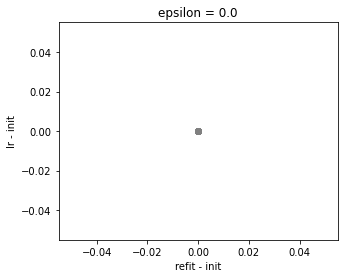

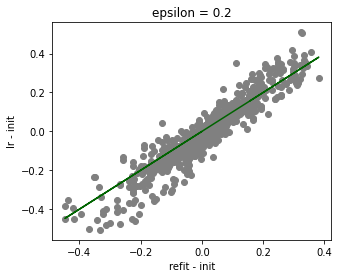

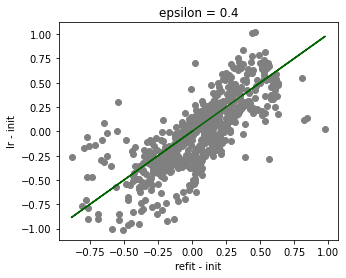

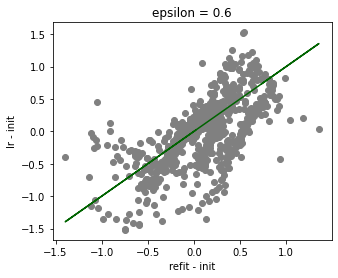

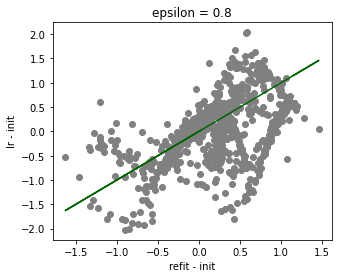

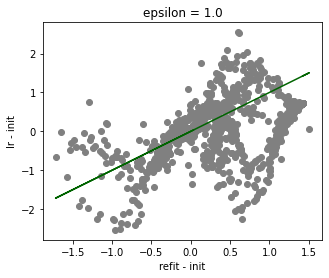

In [15]:
for i in range(len(epsilon_vec)): 
    fig, ax = plt.subplots(1, 1, figsize = (5, 4))

    result_loading_utils.print_diff_plot(refit_list[i], 
                                         lr_list[i],
                                         vb_opt,
                                         ax, 
                                         alpha = 1.)
    
    plt.title('epsilon = {}'.format(epsilon_vec[i]))
    

# Plot admixtures

In [16]:
def get_inferred_admixture_and_plot(vb_free_params, ax): 
    # get inferred admixture
    e_ind_admix = posterior_quantities_lib.get_vb_expectations(\
                                            vb_params_paragami.fold(vb_free_params, free = True), 
                                            gh_loc,
                                            gh_weights)[0]
    
    # plot admixtures
    plotting_utils.plot_top_clusters(onp.array(e_ind_admix)[perm_obs], 
                                     ax,
                                     8, 
                                     cmap_colors = plt.get_cmap('Set2').colors);

    # print labels 
    plotting_utils.draw_region_separation(labels[perm_labels], ax);
    
    return e_ind_admix[perm_obs]

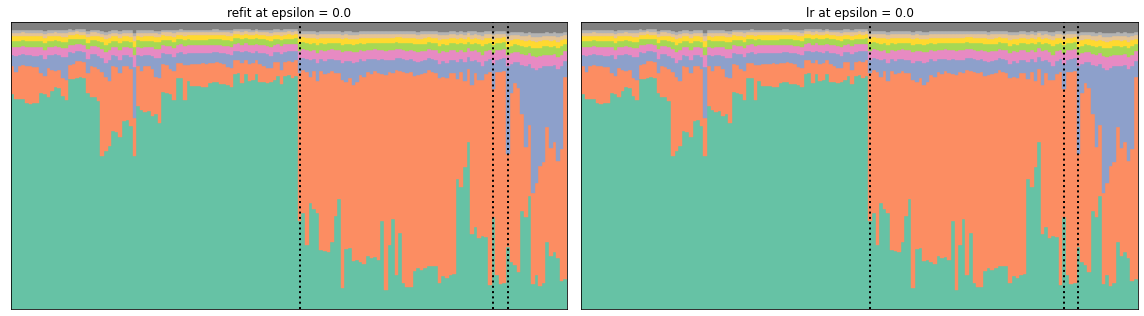

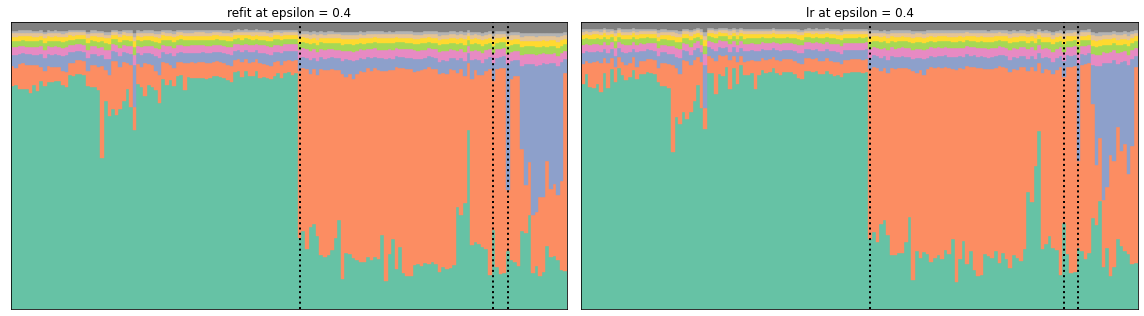

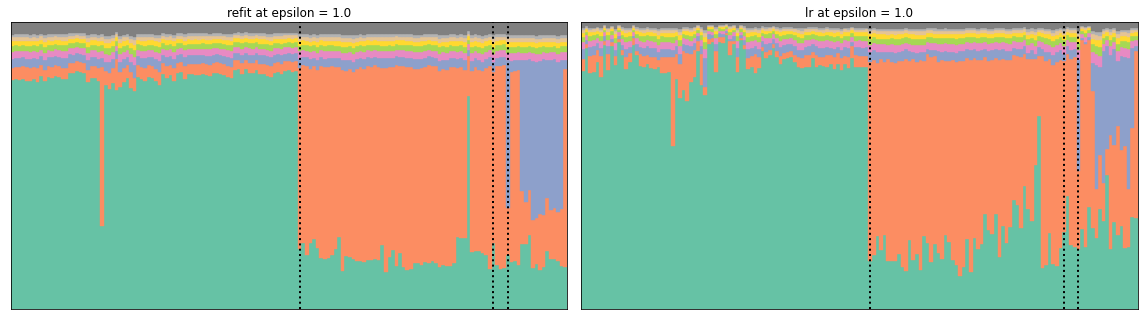

In [17]:
which_epsilons = [0, 2, -1]

admix_lr_list = []
admix_refit_list = []

for i in which_epsilons: 

    fig, ax = plt.subplots(1, 2, figsize = (16, 4.5))
    
    ax[0].set_title('refit at epsilon = {}'.format(epsilon_vec[i]))
    ax[1].set_title('lr at epsilon = {}'.format(epsilon_vec[i]))
    
    # refit
    admix_refit = get_inferred_admixture_and_plot(refit_list[i], ax[0])
    
    # lr 
    admix_lr = get_inferred_admixture_and_plot(lr_list[i], ax[1])
    
    # just remove these labels for now
    for j in range(2): 
        ax[j].set_xticks([]) 

    fig.tight_layout()
    
    
    admix_refit_list.append(admix_refit)
    admix_lr_list.append(admix_lr)

# Lets look at that long strip in the mbololo region ... 

In [18]:
refit_dict = vb_params_paragami.fold(refit_list[-1], free = True)
e_ind_admix_pert = posterior_quantities_lib.get_vb_expectations(refit_dict, gh_loc, gh_weights)[0]

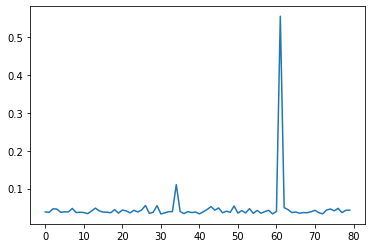

In [19]:
plt.plot(e_ind_admix_pert[labels == 'Mbololo'][:, 1])

In [20]:
np.argwhere((labels == 'Mbololo') & (e_ind_admix_pert[:, 1] > 0.5))

DeviceArray([[78]], dtype=int64)

In [21]:
n = 78

In [22]:
def get_e_ind_admix_k(vb_free, k): 
    e_ind_admix = posterior_quantities_lib.get_vb_expectations(\
                                            vb_params_paragami.fold(vb_free, free = True), 
                                            gh_loc,
                                            gh_weights)[0]
    
    return e_ind_admix[n, k]

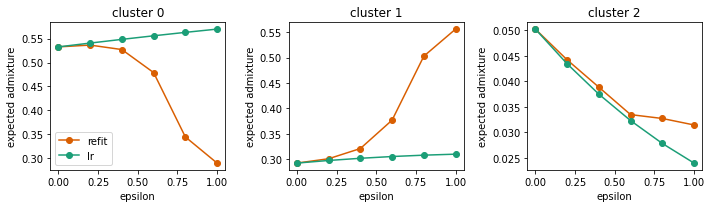

In [23]:
fig, axarr = plt.subplots(1, 3, figsize = (10, 3), sharey = False)


for k in range(3): 
    result_loading_utils.plot_post_stat_per_epsilon(lambda x : get_e_ind_admix_k(x, k),
                                                    refit_list,
                                                    lr_list,
                                                    epsilon_vec, 
                                                    axarr[k])
    
    axarr[k].set_title('cluster {}'.format(k))
    axarr[k].set_ylabel('expected admixture')
    
axarr[0].legend()
fig.tight_layout()

In [24]:
def get_stick_means_k(vb_free, k): 
    vb_params_dict = vb_params_paragami.fold(vb_free, free = True)
    
    return vb_params_dict['ind_admix_params']['stick_means'][n, k]

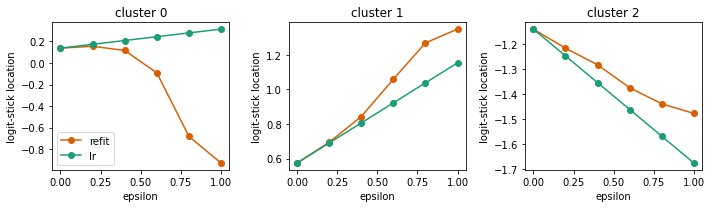

In [25]:
fig, axarr = plt.subplots(1, 3, figsize = (10, 3), sharey = False)


for k in range(3): 
    result_loading_utils.plot_post_stat_per_epsilon(lambda x : get_stick_means_k(x, k),
                                                    refit_list,
                                                    lr_list,
                                                    epsilon_vec, 
                                                    axarr[k])
    
    axarr[k].set_title('cluster {}'.format(k))
    axarr[k].set_ylabel('logit-stick location')
    
axarr[0].legend()
fig.tight_layout()

# save results

In [69]:
if save_data: 
    np.savez(out_datadir + 'mbololo_fsens_admix_example', 
         epsilon = epsilon_vec[-1], 
         admix_refit = admix_refit_list[-1], 
         admix_lr = admix_lr_list[-1])

In [70]:
import pandas as pd 

### save logit stick location parameter

In [99]:
logit_stick_loc_df = pd.DataFrame()

for k in range(3):
    
    refit_vec = \
        result_loading_utils.get_post_stat_vec(lambda x : get_stick_means_k(x, k),
                                               refit_list)
    
    lr_vec = \
        result_loading_utils.get_post_stat_vec(lambda x : get_stick_means_k(x, k),
                                               lr_list)
    
    
    refit_df = pd.DataFrame({'logit_stick_location': refit_vec, 
                             'epsilon': epsilon_vec, 
                             'population': k + 1, 
                             'epsilon': epsilon_vec, 
                             'method': 'refit'})


    lr_df = pd.DataFrame({'logit_stick_location': lr_vec, 
                          'epsilon': epsilon_vec, 
                          'population': k + 1, 
                          'epsilon': epsilon_vec, 
                          'method': 'lin'})
    
    logit_stick_loc_df = logit_stick_loc_df.append(refit_df)
    logit_stick_loc_df = logit_stick_loc_df.append(lr_df)

In [100]:
logit_stick_loc_df.to_csv(out_datadir + 'mbololo_logit_stick_bad_example.csv')

### save mixture weights

In [101]:
admix_i_df = pd.DataFrame()

for k in range(3):
    
    refit_vec = \
        result_loading_utils.get_post_stat_vec(lambda x : get_e_ind_admix_k(x, k),
                                               refit_list)
    
    lr_vec = \
        result_loading_utils.get_post_stat_vec(lambda x : get_e_ind_admix_k(x, k),
                                               lr_list)
    
    
    refit_df = pd.DataFrame({'admix': refit_vec, 
                             'epsilon': epsilon_vec, 
                             'population': k + 1, 
                             'epsilon': epsilon_vec, 
                             'method': 'refit'})


    lr_df = pd.DataFrame({'admix': lr_vec, 
                          'epsilon': epsilon_vec, 
                          'population': k + 1, 
                          'epsilon': epsilon_vec, 
                          'method': 'lin'})
    
    admix_i_df = admix_i_df.append(refit_df)
    admix_i_df = admix_i_df.append(lr_df)

In [102]:
admix_i_df.to_csv(out_datadir + 'mbololo_admix_bad_example.csv')

In [42]:
logit_stick_loc_df

,logit_stick_location,population,method
0,-1.140769,2,lr
1,-1.216948,2,lr
2,-1.283100,2,lr
3,-1.374692,2,lr
4,-1.438738,2,lr
5,-1.477117,2,lr


In [ ]:
logit_stick_loc_df_k = 

In [29]:
logit_stick_loc_df.append()

TypeError: append() missing 1 required positional argument: 'other'